# Rock Paper Scissors - Pytorch Multiclass Classifier
In this workbook we illustrate multi-class image classification of the [Rock Paper Scissors dataset](https://www.kaggle.com/drgfreeman/rockpaperscissors), which is downloaded from Kaggle from the above URL. You'll need to login with your Kaggle ID to download the dataset. The data was downloaded and un-zipped to the `./data/RockPaperScissors` folder

In [1]:
# set this flag to True when you run this Notebook on Google Collaboratory
USE_COLAB = True

In [6]:
# Run this ONLY in Colab (For some reason, Colab does not have torchmetrics installed)
if USE_COLAB:
    !pip install -q torchmetrics
    !pip install -q kaggle

In [7]:
import os

# @see: https://colab.research.google.com/drive/1srw_HFWQ2SMgmWIawucXfusGzrj1_U0q
if USE_COLAB:
    # Connect to Google drive, so I can import modules from it into my workspace
    # Load the Drive helper and mount
    from google.colab import drive

    # This will prompt for authorization.
    gdrive_mount_point = '/content/drive/'
    drive.mount(gdrive_mount_point)
    grive_path = os.path.join(gdrive_mount_point, "My Drive/")
    print('Your Google Drive is mounted at ', grive_path)
    COLAB_NOTEBOOKS_PATH = os.path.join(grive_path, "ColabNotebooks/")

    if os.path.exists(COLAB_NOTEBOOKS_PATH):
        # display list of files
        #!ls '/content/drive/My Drive/Colab Notebooks/'

        # append our Google Drive folder to module search
        # **NOTE:** comment this line out if you are NOT running this notebook on Google Colab
        import sys
        import pathlib
        pyt_path = os.path.join(COLAB_NOTEBOOKS_PATH, 'Pytorch')
        sys.path.append(pyt_path)
        print('You Pytorch Colab notebooks are available at ', pyt_path)
        print('NOTE: {} is appended to sys.path!'.format(pyt_path))
        # and test it
        import pytorch_training_toolkit as t3
        save_path = pathlib.Path("/content") / "model_states"
        if not save_path.exists():
            save_path.mkdir()
        MODEL_SAVE_DIR = save_path.__str__()
    else:
        raise IOError("Unable to mount Google Drive!")
else:
    MODEL_SAVE_DIR = os.path.join('.', 'model_states')

if not os.path.exists(MODEL_SAVE_DIR):
    os.mkdir(MODEL_SAVE_DIR)

assert os.path.exists(MODEL_SAVE_DIR)
print('MODEL_SAVE_DIR = %s' % MODEL_SAVE_DIR)


Mounted at /content/drive/
Your Google Drive is mounted at  /content/drive/My Drive/
You Pytorch Colab notebooks are available at  /content/drive/My Drive/ColabNotebooks/Pytorch
NOTE: /content/drive/My Drive/ColabNotebooks/Pytorch is appended to sys.path!
MODEL_SAVE_DIR = /content/model_states


In [8]:
import warnings
warnings.filterwarnings('ignore')

import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import glob
from PIL import Image

# tweaks for libraries
np.set_printoptions(precision=6, linewidth=1024, suppress=True)
plt.style.use('seaborn')
sns.set_style('darkgrid')
sns.set_context('notebook',font_scale=1.0)

# Pytorch imports
import torch
gpu_available = torch.cuda.is_available()
print('Using Pytorch version: %s. GPU %s available' % (torch.__version__, "IS" if gpu_available else "is NOT"))
import torch.nn as nn
from torchvision import datasets, transforms
import torchsummary
# My helper functions for training/evaluating etc.
if USE_COLAB:
    # single file code (as Colab appears to have issues importing Modules)
    import pytorch_training_toolkit as t3
else:
    import torch_training_toolkit as t3

SEED = 41
t3.seed_all(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Will train model on {DEVICE}")

Using Pytorch version: 1.13.1+cu116. GPU IS available
Will train model on cuda


## Downloading the dataset from Kaggle
You can download datasets directly from Kaggle by running the following steps:
* The following 3 steps have to be done only once - if you have already installed kaggle-cli package, ignore these:
    * Login to your Kaggle account and _create a new API Token_ from your profile page (click the `Create API Token` button and download the `kaggle.json` file locally i.e. to your disk.
    * If using Colab:
        * Upload the `kaggle.json` that you downloaded to Colab  and move the file to `~/.kaggle/kaggle.json`
    * From your desktop environment:
        * Copy `kaggle.json` to $HOME/.kaggle folder (on *nix) of c:\\Users\\<<user_name>>\\.kaggle folder on Windows (create) the .kaggle folder if it does not exist.
    * Install Python packages `kaggle` and `kaggle-cli` that needed to access Kaggle programatically. These can be installed using `pip` as follows:
        ```shell
            $> pip install kaggle kaggle-cli
        ```
* Now you can download the Rock-Paper-Scissors dataset as follows (on command line or cell in Notebook)
    ```shell
    $> !kaggle datasets download -d drgfreeman/rockpaperscissors -p <<target_folder>>
    ```

In [9]:
if USE_COLAB:
    !mkdir -p ~/.kaggle
    !cp "/content/drive/My Drive/ColabNotebooks/kaggle.json" ~/.kaggle/

In [22]:
!chmod 600 ~/.kaggle/kaggle.json

In [29]:
!rm -r /content/data/rps-cv-images 

In [10]:
if USE_COLAB:
    # in google colab
    !mkdir -p /content/data
    !kaggle datasets download -d drgfreeman/rockpaperscissors -p /content/data
    !mkdir /content/data/RockPaperScissors
    !unzip /content/data/rockpaperscissors.zip -v -d /content/data/RockPaperScissors
    !rm -r /content/data/rps-cv-images
else:
    target_dir = pathlib.Path(os.getcwd()) / "data" / "kaggle"
    !kaggle datasets download -d drgfreeman/rockpaperscissors -p $target_dir
    # will download rockpaperscissors.zip to kaggle folder - navigate to that folder & unzip
    # the zip file - it will create a sub-folder RockPaperScissors

401 - Unauthorized
unzip:  cannot find or open /content/data/rockpaperscissors.zip, /content/data/rockpaperscissors.zip.zip or /content/data/rockpaperscissors.zip.ZIP.


In [30]:
CLASSES = ['rock', 'paper', 'scissors']

In [31]:
if USE_COLAB:
    IMAGES_BASE_PATH = (pathlib.Path("/content") / 'data' / 'RockPaperScissors')
else:
    IMAGES_BASE_PATH = (pathlib.Path.cwd() / 'data' / 'kaggle' / 'RockPaperScissors')
print(IMAGES_BASE_PATH)

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()   
])

rps_dataset = datasets.ImageFolder(IMAGES_BASE_PATH, transform=image_transforms)
print(f"Total number of images {len(rps_dataset)}")
train_dataset, test_dataset = t3.split_dataset(rps_dataset, split_perc=0.3)
val_dataset, test_dataset = t3.split_dataset(test_dataset, split_perc=0.1)
print(
    f"No of images in train_dataset: {len(train_dataset)} - cross-val: {len(val_dataset)} - test: {len(test_dataset)}"
)


/content/data/RockPaperScissors
Total number of images 2188
No of images in train_dataset: 1531 - cross-val: 591 - test: 66


images.shape: (64, 3, 224, 224) - labels.shape: (64,)


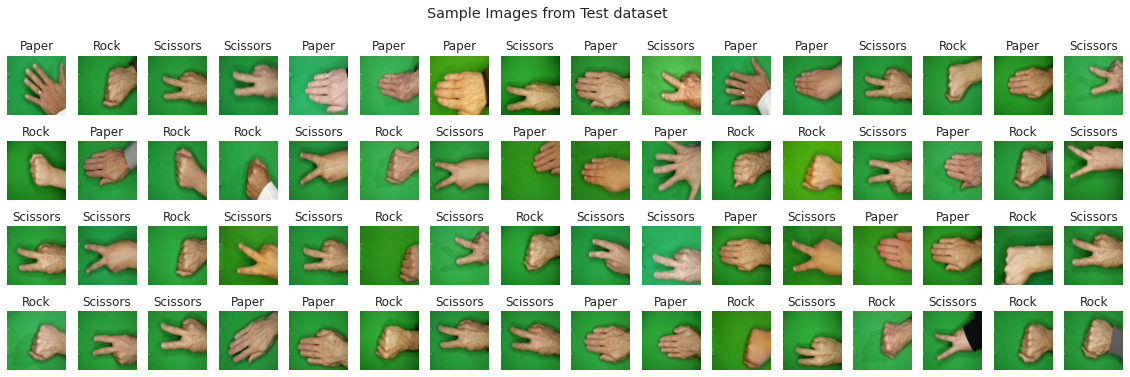

In [33]:
# display some images from train_dataset
LABELS = ['Paper', 'Rock', 'Scissors']  
trainloader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)
data_iter = iter(trainloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

plt.figure(figsize=(20, 6))
for i in range(64):
    plt.subplot(4, 16, i + 1)
    image = sample_images[i]
    # label_text = "Pos" if sample_labels[i] == 1 else "Neg"
    label_text = LABELS[sample_labels[i]]
    # print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1, 2, 0))
    # print(f" - AP: images[{i}].shape: {image.shape}")
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(label_text)
    plt.axis('off')
plt.suptitle("Sample Images from Test dataset")
plt.show()
plt.close()

## Build the model

### Train the model

In [34]:
IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS, NUM_CLASSES = 224, 224, 3, 3
NUM_EPOCHS, BATCH_SIZE, LEARNING_RATE, L2_LAMBDA = 100, 64, 1e-2, 1e-2
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, "pyt_rock_paper_scissors.pt")

In [35]:
from PIL import Image

def get_data(image_paths):
    # NOTE: image_paths is a list of Path objects
    images, labels = [], []

    for image_path in image_paths:
        image = Image.open(image_path) 
        image = image.resize((IMAGE_WIDTH, IMAGE_HEIGHT)) # load_img(image_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
        image = np.array(image)
        label_name = image_path.parts[-2] # image_path.split(os.path.sep) [-2]
        label = CLASSES.index(label_name)
        label = np.array(label).astype('int32')
        images.append(image)
        labels.append(label)

        #labels = np.expand_dims(labels, axis=0)

    return np.array(images), np.array(labels)

In [36]:
file_pattern = IMAGES_BASE_PATH /  '*' / '*.png'
dataset_paths = list(IMAGES_BASE_PATH.glob("*/*.png"))  # [*glob.glob(str(file_pattern))]
random.shuffle(dataset_paths)
images, labels = get_data(dataset_paths)
print(f"images.shape: {images.shape} - labels.shape: {labels.shape}")

images.shape: (2188, 224, 224, 3) - labels.shape: (2188,)


In [37]:
dataset_paths[:10]

[PosixPath('/content/data/RockPaperScissors/rock/IY007WkIgMgYMJRj.png'),
 PosixPath('/content/data/RockPaperScissors/paper/pUCjvjdpH5HSaWxl.png'),
 PosixPath('/content/data/RockPaperScissors/rock/Yzx0RwB2AFNAvC6s.png'),
 PosixPath('/content/data/RockPaperScissors/paper/oWI7JL85eXDhRFcV.png'),
 PosixPath('/content/data/RockPaperScissors/scissors/e1qGNUkh9ecj7QG3.png'),
 PosixPath('/content/data/RockPaperScissors/rock/rtyjzSfCZlfTPTox.png'),
 PosixPath('/content/data/RockPaperScissors/rock/2MKZD0VUw7Tez2Jx.png'),
 PosixPath('/content/data/RockPaperScissors/scissors/1yDUM1w2HTbuPIfO.png'),
 PosixPath('/content/data/RockPaperScissors/scissors/cDveaur4dR2ZCCo8.png'),
 PosixPath('/content/data/RockPaperScissors/scissors/R8EezCr0SD3e39T0.png')]

In [38]:
np.bincount(labels.astype('int32')), labels[:10]

(array([726, 712, 750]), array([0, 1, 0, 1, 2, 0, 0, 2, 2, 2], dtype=int32))

In [39]:
class RPSModule(nn.Module):
    def __init__(self):
        super(RPSModule, self).__init__()
        self.net = net = nn.Sequential(
            nn.Conv2d(NUM_CHANNELS, 32, kernel_size=5, padding=1), # 20
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),

            nn.Conv2d(32, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),       

            nn.Conv2d(64, 64, kernel_size=5, padding=1), # 32
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.4),     

            nn.Flatten(),
            nn.Dropout(0.4),

            nn.Linear(64*26*26, 512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, 3)
        )

    def forward(self, x):
        return self.net(x)

In [40]:
from sklearn.model_selection import train_test_split

# split dataset into train/test sets in 70:30 ration
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, 
                                                    random_state=SEED, stratify=labels)
# split the test set into cross-val & test datasets in 80:20 rstio
# NOTE: Andrew Ng recommends that, if possible, the test & cv datasets should be drawn
# from the same sample
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.3, 
                                                random_state=SEED, stratify=y_test)

print(f"X_train.shape: {X_train.shape} - y_train.shape: {y_train.shape} - class dist: {np.bincount(y_train)}\n" +
      f"X_val.shape: {X_val.shape} - y_val.shape: {y_val.shape} - class dist: {np.bincount(y_val)}\n" +
      f"X_test.shape: {X_test.shape} - y_test.shape: {y_test.shape} - class dist: {np.bincount(y_test)}") 

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_val = y_val.astype('float32')

X_train.shape: (1531, 224, 224, 3) - y_train.shape: (1531,) - class dist: [508 498 525]
X_val.shape: (459, 224, 224, 3) - y_val.shape: (459,) - class dist: [152 150 157]
X_test.shape: (198, 224, 224, 3) - y_test.shape: (198,) - class dist: [66 64 68]


In [41]:
# define a dataset for Pytorch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class RPSDataset(Dataset):
    def __init__(self, x, y, transforms=None):
        self.x = x
        self.y = torch.LongTensor(y)
        self.transforms = transforms

    def __len__(self):
        return len(self.x)

    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        if self.transforms is not None:
            x = self.transforms(x)
        return x, y
    

means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
    transforms.RandomAffine(0, shear=0.2),         # random shear 0.2
    transforms.RandomAffine(0, scale=(0.8, 1.2)),  # random zoom 0.2
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),   
    transforms.RandomVerticalFlip(),   
    transforms.CenterCrop((IMAGE_HEIGHT, IMAGE_WIDTH)),  
])
    
image_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds)
    # transforms.Resize((128, 128)),
    #transforms.CenterCrop((128, 128)),
])

In [42]:
train_dataset = RPSDataset(X_train, y_train, train_transforms)
val_dataset = RPSDataset(X_val, y_val, image_transforms)
test_dataset = RPSDataset(X_test, y_test, image_transforms)

images.shape: (32, 3, 224, 224) - labels.shape: (32,)


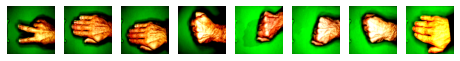

In [43]:
testloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image) # image.squeeze())
    plt.axis('off')
    if i > 6:
        break
plt.show()
plt.close()

images.shape: (32, 3, 224, 224) - labels.shape: (32,)


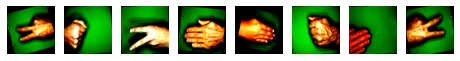

In [45]:
testloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

#plt.figure(figsize=(5,5))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    image = sample_images[i]
    #print(f"images[{i}].shape: {image.shape} ")
    image = image.transpose((1,2,0))
    #print(f" - AP: images[{i}].shape: {image.shape}")
    #plt.imshow(image.squeeze(), cmap='gray')
    plt.imshow(image) 
    plt.axis('off')
    if i > 6:
        break
plt.show()
plt.close()

In [46]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score

metrics_map = {
    "acc": MulticlassAccuracy(num_classes=NUM_CLASSES),
    "f1": MulticlassF1Score(num_classes=NUM_CLASSES)
}
loss_fn = torch.nn.CrossEntropyLoss()

trainer = t3.Trainer(
    loss_fn=loss_fn, device=DEVICE, metrics_map=metrics_map,
    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE
)


In [47]:
from torch.optim.lr_scheduler import StepLR
model = RPSModule()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
scheduler = StepLR(optimizer, step_size=NUM_EPOCHS//10, gamma=0.1)
hist = trainer.fit(
    model, optimizer, train_dataset, validation_dataset=val_dataset,
    lr_scheduler=scheduler,
)


Cross training on 'cuda' with 1531 training and 459 cross-validation records...
Epoch (  1/100): (1531/1531) -> loss: 30.9974 - acc: 0.5486 - f1: 0.5166 - val_loss: 14.9782 - val_acc: 0.6520 - val_f1: 0.6149
Epoch (  2/100): (1531/1531) -> loss: 7.3169 - acc: 0.7016 - f1: 0.6940 - val_loss: 2.3258 - val_acc: 0.8767 - val_f1: 0.8746
Epoch (  3/100): (1531/1531) -> loss: 6.4089 - acc: 0.7356 - f1: 0.7283 - val_loss: 10.2541 - val_acc: 0.5425 - val_f1: 0.5027
Epoch (  4/100): (1531/1531) -> loss: 5.3673 - acc: 0.7305 - f1: 0.7239 - val_loss: 3.1915 - val_acc: 0.7635 - val_f1: 0.7514
Epoch (  5/100): (1531/1531) -> loss: 2.8521 - acc: 0.8148 - f1: 0.8072 - val_loss: 1.0504 - val_acc: 0.8812 - val_f1: 0.8744
Epoch (  6/100): (1531/1531) -> loss: 2.3145 - acc: 0.8281 - f1: 0.8183 - val_loss: 1.7756 - val_acc: 0.7968 - val_f1: 0.7984
Epoch (  7/100): (1531/1531) -> loss: 1.7750 - acc: 0.8476 - f1: 0.8433 - val_loss: 0.4749 - val_acc: 0.9306 - val_f1: 0.9329
Epoch (  8/100): (1531/1531) -> los

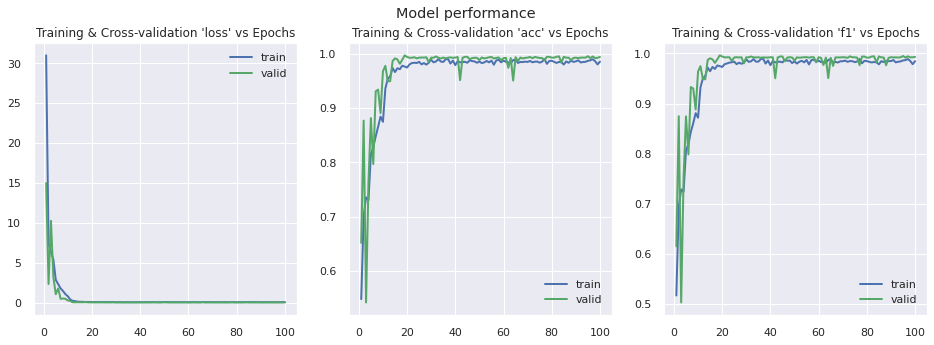

In [48]:
hist.plot_metrics(title="Model performance")

In [49]:
print("Evaluating model...")
metrics = trainer.evaluate(model, train_dataset)
print(f"  Training dataset  -> loss: {metrics['loss']:.3f} - acc: {metrics['acc']:.3f}")
metrics = trainer.evaluate(model, val_dataset)
print(f"  Cross-val dataset -> loss: {metrics['loss']:.3f} - acc: {metrics['acc']:.3f}")
metrics = trainer.evaluate(model, test_dataset)
print(f"  Test dataset      -> loss: {metrics['loss']:.3f} - acc: {metrics['acc']:.3f}")

Evaluating model...
Evaluating (1531/1531) -> loss: 0.0279 - acc: 0.9940 - f1: 0.9940
  Training dataset  -> loss: 0.028 - acc: 0.994
Evaluating (459/459) -> loss: 0.0209 - acc: 0.9919 - f1: 0.9917
  Cross-val dataset -> loss: 0.021 - acc: 0.992
Evaluating (198/198) -> loss: 0.0391 - acc: 0.9929 - f1: 0.9925
  Test dataset      -> loss: 0.039 - acc: 0.993


#### Observation:
See [this Colab Notebook](https://colab.research.google.com/drive/1brSHFOnPQTo0-9vQRC6oslZjAGRbzWuY) for _examples on inserting tables inside markdown cells_
>Configuration | Training Acc | Cross-val Acc | Test Acc | Observation
>:---|:---:|:---:|:---:|:---:|
>**Model**|99.4%|99.2%|99.3%|Good model

In [50]:
t3.save_model(model, MODEL_SAVE_PATH)
del model

Pytorch model saved to /content/model_states/pyt_rock_paper_scissors.pt


## Run Predictions

In [51]:
model = RPSModule()
model = model.to(DEVICE)
model = t3.load_model(model, MODEL_SAVE_PATH)
print(torchsummary.summary(model, (NUM_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH)))

Pytorch model loaded from /content/model_states/pyt_rock_paper_scissors.pt
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 222, 222]           2,432
              ReLU-2         [-1, 32, 222, 222]               0
       BatchNorm2d-3         [-1, 32, 222, 222]              64
         MaxPool2d-4         [-1, 32, 111, 111]               0
           Dropout-5         [-1, 32, 111, 111]               0
            Conv2d-6         [-1, 64, 109, 109]          51,264
              ReLU-7         [-1, 64, 109, 109]               0
       BatchNorm2d-8         [-1, 64, 109, 109]             128
         MaxPool2d-9           [-1, 64, 54, 54]               0
          Dropout-10           [-1, 64, 54, 54]               0
           Conv2d-11           [-1, 64, 52, 52]         102,464
             ReLU-12           [-1, 64, 52, 52]               0
      BatchNorm2d-13        

In [52]:
y_pred, y_true = trainer.predict(model, test_dataset)
y_pred = np.argmax(y_pred, axis=1)
correct_preds = (y_pred == y_true).sum()
pred_acc = correct_preds / len(y_true)
print(f"We got {correct_preds} predictions of {len(y_true)} samples correct! Test acc: {pred_acc*100.0:.3f}%")

rand_indexes = np.random.randint(0, len(y_true), 64)
print(f"Actuals (50 random samples)    : {y_true[rand_indexes]}")
print(f"Predictions (50 random samples): {y_pred[rand_indexes]}")

We got 196 predictions of 198 samples correct! Test acc: 98.990%
Actuals (50 random samples)    : [2 1 0 1 0 0 1 1 2 2 2 1 0 0 2 2 0 2 2 0 0 2 1 1 0 0 1 2 2 1 1 0 1 2 2 2 0 2 1 2 1 2 0 1 0 0 1 1 2 1 1 2 1 2 2 2 0 1 2 0 2 0 1 1]
Predictions (50 random samples): [2 1 0 1 0 0 1 1 2 2 2 1 0 0 2 2 0 2 2 0 0 2 1 1 0 0 1 2 2 1 1 0 1 2 2 2 0 2 1 2 1 2 0 1 0 0 1 1 2 1 1 2 1 2 2 2 0 1 2 0 2 0 1 1]


images.shape: (64, 3, 224, 224) - labels.shape: (64,)


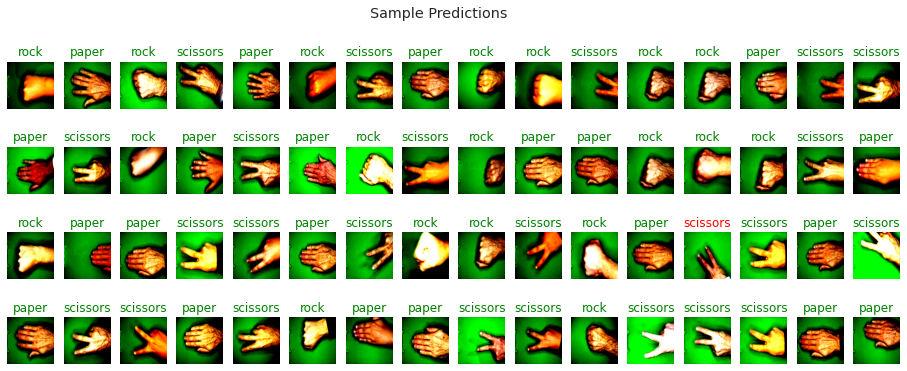

In [57]:
NUM_SAMPLES = 64
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=NUM_SAMPLES, shuffle=False)
data_iter = iter(testloader)
sample_images, sample_labels = next(data_iter)
sample_images, sample_labels = sample_images.cpu().numpy(), sample_labels.cpu().numpy()
predictions = y_pred[:NUM_SAMPLES]
print(f"images.shape: {sample_images.shape} - labels.shape: {sample_labels.shape}")

plt.figure(figsize=(16, 6))
for i in range(NUM_SAMPLES):
    plt.subplot(4, 16, i + 1)
    image = sample_images[i]
    label_text = CLASSES[sample_labels[i]]
    image = image.transpose((1, 2, 0))
    plt.imshow(image, cmap='gray')
    title = plt.title(label_text)
    plt.setp(title, color=("g" if sample_labels[i] == y_pred[i] else "r"))
    plt.axis('off')
plt.suptitle("Sample Predictions")
plt.show()
plt.close()

In [58]:
del model

# <center> -- END -- </center>